In [1]:
import os

import torch

from data_providers.LGDataset import LGDataset, get_dataloader

In [2]:
import math

DIR = 'datasets'
BATCH_SIZE = 2048

train_dataset = LGDataset(os.path.join(DIR, 'train.csv'))
test_dataset = LGDataset(os.path.join(DIR, 'valid.csv'))

# subset 10% of the test dataset for validation, should keep order without shuffling
val_size = math.ceil(len(test_dataset) * 0.1)
val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [val_size, len(test_dataset) - val_size])

train_loader = get_dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = get_dataloader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = get_dataloader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

x,y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([2048, 5]) torch.Size([2048])


In [28]:
from torch import nn

class FeatureWiseAttention(nn.Module):
    def __init__(self, num_features, is_residual=False):
        super(FeatureWiseAttention, self).__init__()
        self.attention = nn.Linear(num_features, num_features)
        self.is_residual = is_residual

    def forward(self, x):
        attention = self.attention(x)
        attention = nn.functional.softmax(attention, dim=-1)
        return  x * attention + x  if self.is_residual else x * attention

class LinearResidualBlock(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearResidualBlock, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.ReLU(),
            nn.BatchNorm1d(output_size),
            nn.Linear(output_size, output_size),
        )
        self.input_mapping = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        return self.model(x) + self.input_mapping(x)

class SoCEstimator(nn.Module):
    def __init__(self, input_size, num_layers=4, hidden_size=128, is_residual=False, uncertainty=False):
        super(SoCEstimator, self).__init__()
        self.uncertainty = uncertainty

        layers = [LinearResidualBlock(input_size, hidden_size)]
        for _ in range(num_layers):
            layers.append(FeatureWiseAttention(hidden_size, is_residual=is_residual))
            layers.append(LinearResidualBlock(hidden_size, hidden_size))
        layers+=[
            nn.Linear(hidden_size, 1 if not uncertainty else 2),
            nn.Sigmoid()
        ]

        if self.uncertainty:
            self.model = nn.Sequential(
                *layers[:-1],
            )
        else:
            self.model = nn.Sequential(
                *layers,
            )
        
        self._kaiming_init()

    def forward(self, x):
        if self.uncertainty:
            x = self.model(x)
            mean, std = torch.chunk(x, 2, dim=1)
            return mean, std
    
        return self.model(x).squeeze()
    
    @torch.jit.ignore
    def _kaiming_init(self):
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight)
                nn.init.zeros_(layer.bias)
    
    @torch.jit.ignore
    def train_model(self, x, y, criterion, optimizer):
        device = next(self.parameters()).device
        x = x.to(device)
        y = y.to(device)
        self.train()
        optimizer.zero_grad()
        if self.uncertainty:
            mu, logvar = self(x)
            loss = criterion(y, logvar, mu)
        else:
            output = self(x)
            loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        return loss
    
    @torch.jit.ignore
    def validate(self, x, y, criterion):
        device = next(self.parameters()).device
        x = x.to(device)
        y = y.to(device)
        self.eval()
        with torch.no_grad():
            if self.uncertainty:
                mu, logvar = self(x)
                loss = criterion(y, logvar, mu)
            else:
                output = self(x)
                loss = criterion(output, y)
        return loss

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [30]:
# model = SoCEstimator(input_size=x.shape[1], num_layers=2, hidden_size=16)  # model_params1
# model = SoCEstimator(input_size=x.shape[1], num_layers=2, hidden_size=16, is_residual=True) # model_params2 0.0051
# model = SoCEstimator(input_size=x.shape[1], num_layers=3, hidden_size=16)   # model_params3 0.0029
# model = SoCEstimator(input_size=x.shape[1], num_layers=5, hidden_size=32, is_residual=True)   # vgood
model = SoCEstimator(input_size=x.shape[1], num_layers=5, hidden_size=8, is_residual=True)   # model_params3 0.0029
print(model)
y_pred = model(x)
print(y.shape, y_pred.shape)

print(f'The model has {count_parameters(model):,} trainable parameters')

SoCEstimator(
  (model): Sequential(
    (0): LinearResidualBlock(
      (model): Sequential(
        (0): Linear(in_features=5, out_features=8, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Linear(in_features=8, out_features=8, bias=True)
      )
      (input_mapping): Linear(in_features=5, out_features=8, bias=True)
    )
    (1): FeatureWiseAttention(
      (attention): Linear(in_features=8, out_features=8, bias=True)
    )
    (2): LinearResidualBlock(
      (model): Sequential(
        (0): Linear(in_features=8, out_features=8, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Linear(in_features=8, out_features=8, bias=True)
      )
      (input_mapping): Linear(in_features=8, out_features=8, bias=True)
    )
    (3): FeatureWiseAttention(
      (attention): Linear(in_features=8, out_features=8, bias=True)
 

#### Model Deployment

In [31]:
# Model deployment
## Uncomment when needed


In [32]:
import numpy as np

class EarlyStopping:
    def __init__(self, patience=10, delta=0, checkpoint_path='checkpoint.pt'):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.checkpoint_path = checkpoint_path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if val_loss < self.val_loss_min:
            torch.save(model.state_dict(), self.checkpoint_path)
            self.val_loss_min = val_loss
            print('Model saved!')

In [33]:
# write the training function and record in tensorboard
from torch.utils.tensorboard import SummaryWriter

def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs=100, device='cuda'):
    model.to(device)
    writer = SummaryWriter()
    early_stopping = EarlyStopping(patience=10)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            loss = model.train_model(x, y, criterion, optimizer)
            train_loss += loss.item()
        train_loss /= len(train_loader)
        writer.add_scalar('Loss/train', train_loss, epoch)
        
        val_loss = 0
        for x, y in val_loader:
            loss = model.validate(x, y, criterion)
            val_loss += loss.item()
        val_loss /= len(val_loader)
        writer.add_scalar('Loss/val', val_loss, epoch)
        
        print(f'Epoch {epoch} train loss: {train_loss}, val loss: {val_loss}')
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print('Early stopping')
            break
        scheduler.step()
    writer.close()

In [34]:
# train the model
# train_model(model, train_loader, val_loader, nn.MSELoss(), torch.optim.AdamW(model.parameters(), lr=1e-3))

In [35]:
# test model
model.load_state_dict(torch.load('checkpoint.pt'))
model.to('cuda')
test_loss = 0
test_dataset = LGDataset(os.path.join(DIR, 'UDDS_25degC_NO_C_Offset.csv'))
test_loader = get_dataloader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
for x, y in test_loader:
    loss = model.validate(x, y, nn.MSELoss())
    test_loss += loss.item()
test_loss /= len(test_loader)

# print test loss, mse, rmse, mae
print(f'Test loss: {test_loss}')
y_preds = []
y_trues = []
for x, y in test_loader:
    y_preds.append(model(x.to('cuda')).detach().cpu().numpy())
    y_trues.append(y.numpy())
y_preds = np.concatenate(y_preds)
y_trues = np.concatenate(y_trues)
mse = np.mean((y_preds - y_trues) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_preds - y_trues))
maxe = np.max(np.abs(y_preds - y_trues))
print(f'MSE%: {mse*100:.3f}, RMSE%: {rmse*100:.3f}, MAE%: {mae*100:.3f}, MAXE%: {maxe*100:.3f}')

/tmp/ipykernel_26083/3545013622.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


Test loss: 0.0002747349822129763
MSE%: 0.024, RMSE%: 1.538, MAE%: 0.848, MAXE%: 9.695


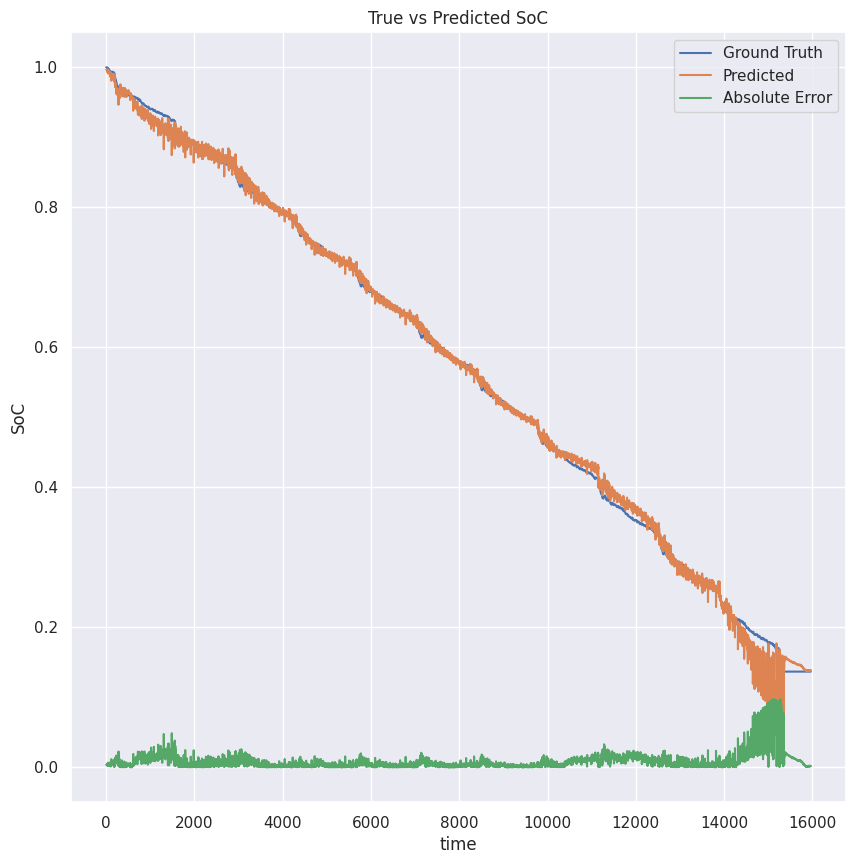

In [36]:
# plot the results
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

plt.figure(figsize=(10, 10))
plt.plot(y_trues)
plt.plot(y_preds)
plt.plot(np.abs(y_preds - y_trues))
plt.xlabel('time')
plt.ylabel('SoC')
plt.legend(['Ground Truth', 'Predicted', 'Absolute Error'])
plt.title('True vs Predicted SoC')
plt.show()

In [37]:
test_files = [
    '01_TEST_LGHG2@n10degC_Norm_(05_Inputs).csv',
    '02_TEST_LGHG2@0degC_Norm_(05_Inputs).csv',
    '03_TEST_LGHG2@10degC_Norm_(05_Inputs).csv',
    '04_TEST_LGHG2@25degC_Norm_(05_Inputs).csv',
]

all_y_preds = []
all_y_trues = []

for test_file in test_files:
    test_dataset = LGDataset(os.path.join(DIR, test_file))
    test_loader = get_dataloader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    y_preds = []
    y_trues = []
    for x, y in test_loader:
        y_preds.append(model(x.to('cuda')).detach().cpu().numpy())
        y_trues.append(y.numpy())
    y_preds = np.concatenate(y_preds)
    y_trues = np.concatenate(y_trues)
    all_y_preds.append(y_preds)
    all_y_trues.append(y_trues)

all_y_preds = np.concatenate(all_y_preds)
all_y_trues = np.concatenate(all_y_trues)

mse = np.mean((all_y_preds - all_y_trues) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(all_y_preds - all_y_trues))
maxe = np.max(np.abs(all_y_preds - all_y_trues))

print(f'MSE%: {mse*100:.3f}, RMSE%: {rmse*100:.3f}, MAE%: {mae*100:.3f}, MAXE%: {maxe*100:.3f}')

MSE%: 0.015, RMSE%: 1.234, MAE%: 0.796, MAXE%: 9.750


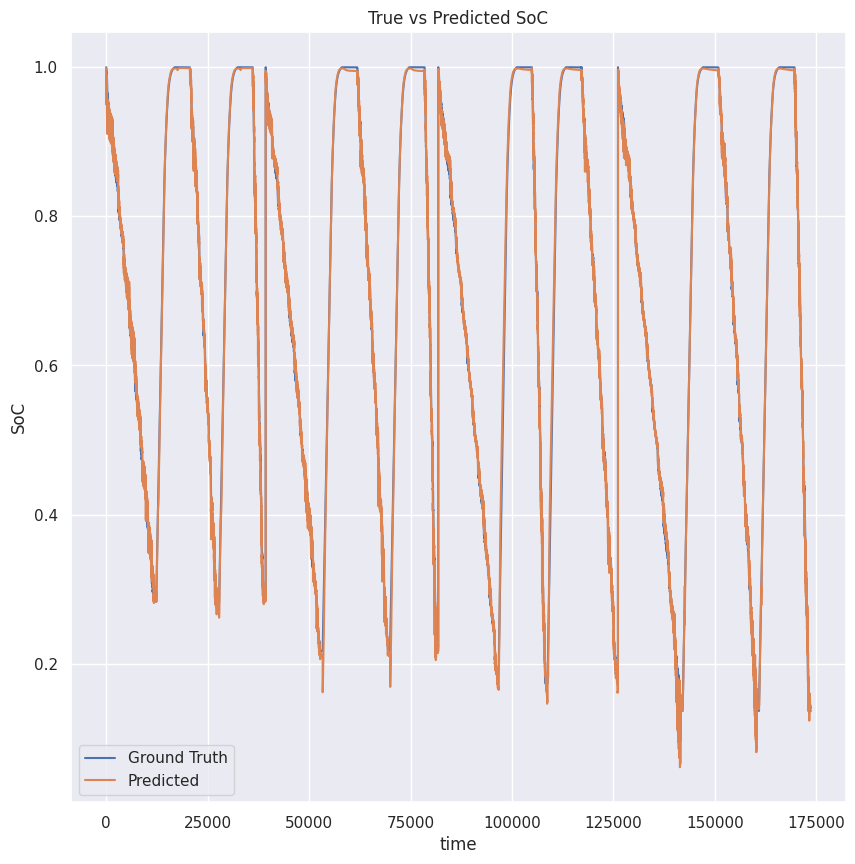

In [38]:
# plot the results
plt.figure(figsize=(10, 10))
plt.plot(all_y_trues)
plt.plot(all_y_preds)

plt.xlabel('time')
plt.ylabel('SoC')
plt.legend(['Ground Truth', 'Predicted'])
plt.title('True vs Predicted SoC')
plt.show()

In [16]:
# plot the attention map
def plot_attention(model, x):
    features = model.model[0](x)
    attention = model.model[1].attention(features)
    print(attention.shape)
    plt.figure(figsize=(10, 10))
    plt.imshow(attention.detach().cpu().numpy(), aspect='auto')
    plt.colorbar()
    plt.title('Attention')
    plt.show()

torch.Size([1628, 8])


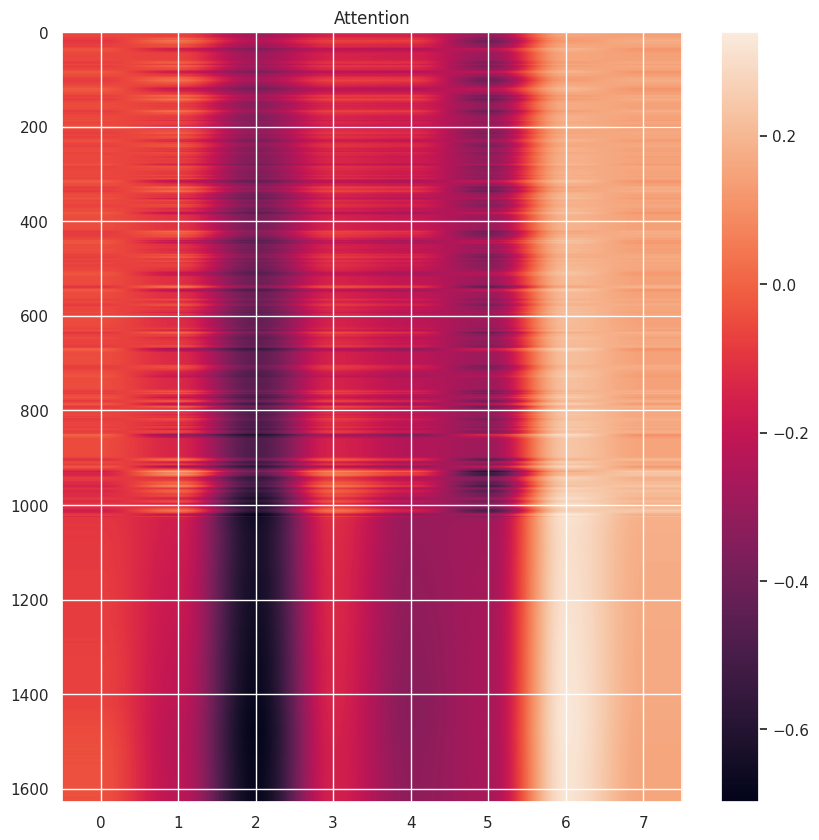

In [17]:
plot_attention(model, x.to('cuda'))

In [18]:
def gaussian_nll(
    mu: torch.Tensor, log_var: torch.Tensor, x: torch.Tensor
) -> torch.Tensor:
    """
    Gaussian negative log likelihood

    Parameters
    ----------
    mu : torch.Tensor
        Mean of the Gaussian
    log_var : torch.Tensor
        Log variance of the Gaussian
    x: torch.Tensor
        Observation

    Returns
    -------
    torch.Tensor
        Negative log likelihood of the observation under the Gaussian
    """
    return torch.mean(0.5 * (np.log(2 * np.pi) + log_var + (x - mu) ** 2 / torch.exp(log_var)))

In [19]:
model = SoCEstimator(input_size=x.shape[1], num_layers=15, hidden_size=32, is_residual=True, uncertainty=True)
mu, logvar = model(x)
print(mu.shape, logvar.shape)

torch.Size([1628, 1]) torch.Size([1628, 1])


In [100]:
train_model(model, train_loader, val_loader, gaussian_nll, torch.optim.AdamW(model.parameters(), lr=1e-3))

Epoch 0 train loss: 0.35055317239063544, val loss: 0.10842421650886536
Model saved!
Epoch 1 train loss: 0.320987116454578, val loss: 0.148433156311512
EarlyStopping counter: 1 out of 10
Epoch 2 train loss: 0.32027844503158476, val loss: 0.11952155083417892
EarlyStopping counter: 2 out of 10
Epoch 3 train loss: 0.32035040809977344, val loss: 0.15101362019777298
EarlyStopping counter: 3 out of 10
Epoch 4 train loss: 0.32012707967220283, val loss: 0.159956693649292
EarlyStopping counter: 4 out of 10
Epoch 5 train loss: 0.320172530667084, val loss: 0.14229224622249603
EarlyStopping counter: 5 out of 10
Epoch 6 train loss: 0.3200767484561699, val loss: 0.13264264911413193
EarlyStopping counter: 6 out of 10
Epoch 7 train loss: 0.3200682600642123, val loss: 0.12314853444695473
EarlyStopping counter: 7 out of 10
Epoch 8 train loss: 0.32002257937338296, val loss: 0.1456706002354622
EarlyStopping counter: 8 out of 10
Epoch 9 train loss: 0.320039957943486, val loss: 0.15452364087104797
EarlyStopp

In [101]:
# test model
model.load_state_dict(torch.load('checkpoint.pt'))
model.to('cuda')
test_loss = 0
test_dataset = LGDataset(os.path.join(DIR, 'UDDS_25degC_NO_C_Offset.csv'))
test_loader = get_dataloader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
for x, y in test_loader:
    loss = model.validate(x, y, gaussian_nll)
    test_loss += loss.item()
test_loss /= len(test_loader)

# print test loss, mse, rmse, mae
print(f'Test loss: {test_loss}')
y_preds = []
y_trues = []
logvars = []
for x, y in test_loader:
    mu, logvar = model(x.to('cuda'))
    y_preds.append(mu.detach().cpu().numpy())
    y_trues.append(y.numpy())
    logvars.append(logvar.detach().cpu().numpy())
y_preds = np.concatenate(y_preds)
y_trues = np.concatenate(y_trues)

mse = np.mean((y_preds - y_trues) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_preds - y_trues))
maxe = np.max(np.abs(y_preds - y_trues))
print(f'MSE%: {mse*100:.3f}, RMSE%: {rmse*100:.3f}, MAE%: {mae*100:.3f}, MAXE%: {maxe*100:.3f}')

C:\Users\ahmed\AppData\Local\Temp\ipykernel_10156\3354980276.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


Test loss: 0.1197991413064301
MSE%: 7.141, RMSE%: 26.723, MAE%: 22.572, MAXE%: 56.685


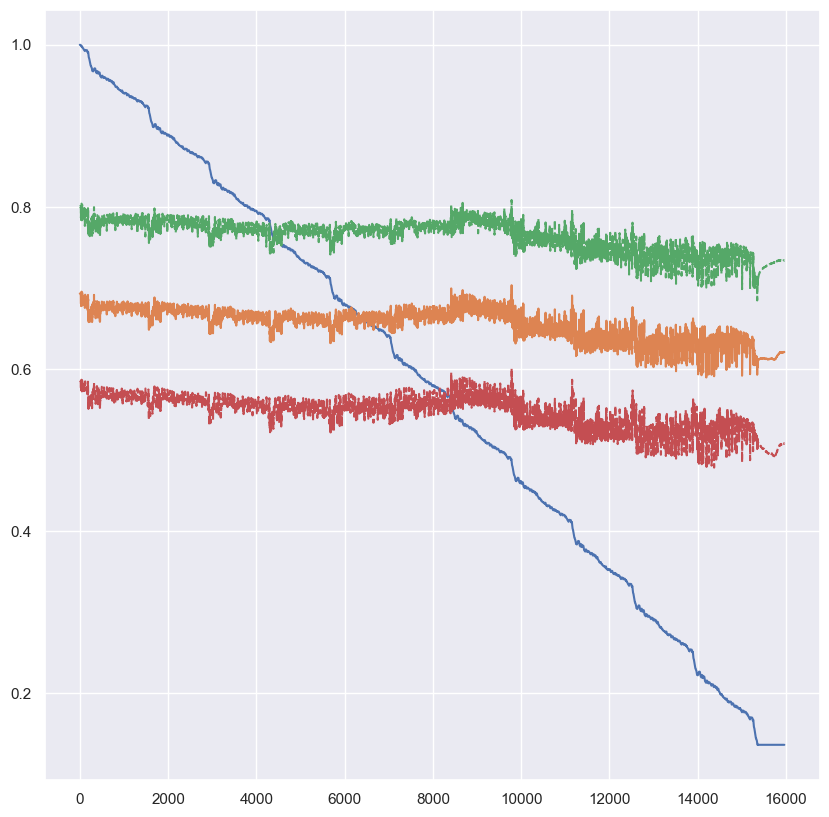

In [102]:
# plot the results
import matplotlib.pyplot as plt

import seaborn as sns

logvars = np.concatenate(logvars)

plt.figure(figsize=(10, 10))
plt.plot(y_trues)
plt.plot(y_preds)
plt.plot(y_preds+np.exp(logvars), linestyle='--')
plt.plot(y_preds-np.exp(logvars), linestyle='--')